In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = (7, 3.5)

def normalize(z):
    return z / np.abs(z)

In [2]:
fs = 30720000

# Start near the first PUCCH transmission
t0 = 0.0217
T = 2e-3
x = np.fromfile('LTE_uplink_847MHz_2022-01-30_30720ksps.sigmf-data', 'int16',
                offset=int(t0*fs*4))

# Scale amplitude so that the PUCCH symbols have roughly the correct amplitude
x = (x[::2] + 1j*x[1::2])/323200
# Correct for CFO. The CFO is measured with the PUSCH and DMRS.
delta_f = -1060

x *= np.exp(1j*(2*np.pi*delta_f/fs*np.arange(x.size)))

In [3]:
# The units here are samples
Tu = 2048 # useful time of a symbol
cp_len = 144  # 4.7 usecs, used in symbols 1-6 in a slot
cp_len2 = 160  # 5.2 usecs, used in symbol 0 in a slot

In [4]:
# Poor man's Schmidl & Cox: correlate the end of each symbol with its own cyclic prefix
cp_corr = np.empty(20*Tu - cp_len - Tu, 'complex64')
for j in range(cp_corr.size):
    # the - sign is to account for the fact that the 7.5 kHz frequency offset
    # of the uplink subcarrier performs a 180 deg rotation during Tu
    cp_corr[j] = -np.sum(x[j:][:cp_len] * np.conjugate(x[j+Tu:][:cp_len]))

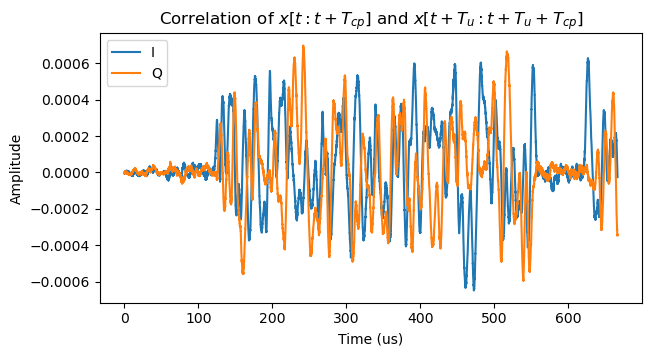

In [5]:
L = 10*Tu
t = np.arange(L)/fs*1e6
plt.plot(t, np.real(cp_corr[:L]))
plt.plot(t, np.imag(cp_corr[:L]))
plt.title('Correlation of $x[t:t+T_{cp}]$ and $x[t+T_u:t+T_u+T_{cp}]$')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude')
plt.legend(['I', 'Q']);

In [6]:
a0 = 3993

In [7]:
slots = 1728 # according to total file length
nsymbols = slots * 7
# Timestamp for each slots. Timestamped to the beginning of
# the cyclic prefix of the first symbol of each slot.
t_slot = t0 + (a0-cp_len2)/fs + np.arange(slots) * 0.5e-3

# All possible RBs used by PUCCH
RBs = [np.arange(724, 736), np.arange(748, 760),
       np.arange(1288, 1300), np.arange(1312, 1324)]

# Here we take into account the 7.5 kHz shift of the uplink
# subcarriers
freq_syms = 7.5e3 + np.fft.fftshift(np.fft.fftfreq(Tu, 1/fs))
freq_syms = [freq_syms[rb] for rb in RBs]

# Extract symbols
symbols = np.empty((nsymbols, 12), 'complex64')
active_rb = np.empty(nsymbols, 'int')
for j in range(nsymbols):
    # For each slot, we need to advance cp_len2-cp_len because of the
    # longer cyclic prefix of the first symbol in each slot. delta counts
    # this.
    delta = (cp_len2 - cp_len) * (j//7)

    # Before performing the FFT, we multiply by an exponential to cancel out the 7.5 kHz shift of
    # the symbols. The phase of this exponential is zero at the start of the symbol.
    syms = np.fft.fftshift(np.fft.fft(x[a0+j*(Tu+cp_len)+delta:][:Tu] * np.exp(-1j*np.pi*np.arange(Tu)/Tu)))
    syms_rb = np.array([syms[rb] for rb in RBs])
    # Power detect the RB in which the transmission happens
    rb = np.argmax(np.sum(np.abs(syms_rb)**2, axis=-1), axis=0)
    active_rb[j] = rb
    # Extract only the subcarriers in that RB
    symbols[j] = syms_rb[rb]
symbols = symbols.reshape((slots, 7, 12))

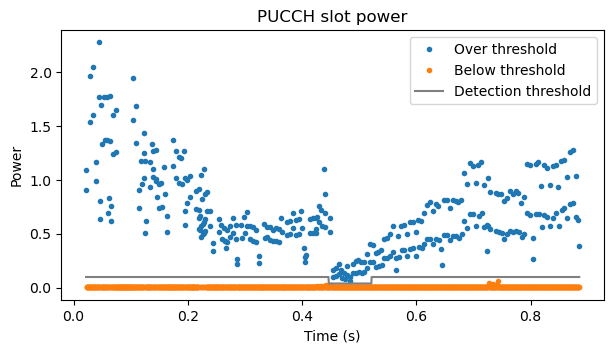

In [8]:
slot_power = np.average(np.abs(symbols)**2, axis=(1, 2))
slot_threshold = np.empty_like(slot_power)
slot_threshold[:] = 0.1
slot_threshold[850:1000] = 0.04
plt.plot(t_slot[slot_power >= slot_threshold], slot_power[slot_power >= slot_threshold],
         '.', label='Over threshold')
plt.plot(t_slot[slot_power < slot_threshold], slot_power[slot_power < slot_threshold], '.',
         label='Below threshold')
plt.plot(t_slot, slot_threshold, color='gray', label='Detection threshold')
plt.title('PUCCH slot power')
plt.ylabel('Power')
plt.xlabel('Time (s)')
plt.legend();

In [9]:
active_slots = np.arange(slots)[slot_power >= slot_threshold]
active_slots.size

356

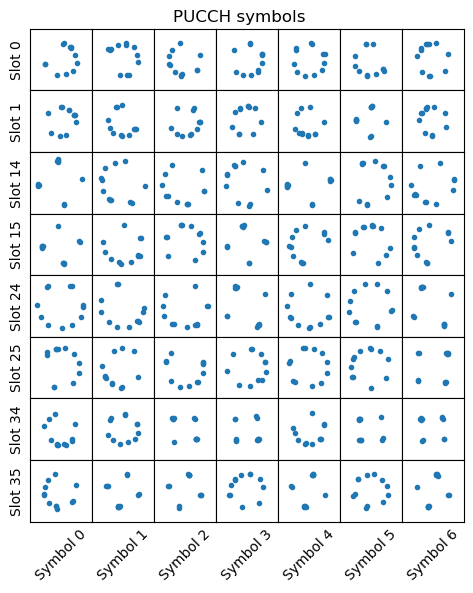

In [10]:
n_active = 8
fig, axs = plt.subplots(n_active, 7, figsize=(5.6, 5.6*n_active/7), facecolor='w', sharex=True, sharey=True)
for slot in range(n_active):
    for sym in range(7):
        ax = axs[slot, sym]
        syms = symbols[active_slots[slot], sym]
        ax.plot(syms.real, syms.imag, '.')
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
        if sym == 0:
            ax.set_ylabel(f'Slot {active_slots[slot]}')
        if slot == axs.shape[0] - 1:
            ax.set_xlabel(f'Symbol {sym}', rotation=45)
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('PUCCH symbols', y=0.91);

In [11]:
rb = active_rb.reshape((slots, 7))
rb = rb[active_slots]
# Check that we have detected the same RB in all the 7 symbols in each slot
assert np.all(rb[:, 0][:, np.newaxis] == rb)
rb = rb[:, 0]

In [12]:
rb

array([1, 2, 0, 3, 0, 3, 2, 1, 0, 3, 3, 0, 0, 3, 0, 3, 0, 3, 2, 1, 0, 3,
       3, 0, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 2, 0, 3, 3, 0, 0, 3,
       1, 2, 0, 3, 0, 3, 1, 2, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3,
       0, 3, 0, 3, 1, 2, 0, 3, 0, 3, 0, 3, 0, 3, 2, 1, 1, 2, 1, 2, 0, 3,
       1, 2, 1, 2, 0, 3, 1, 2, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 2,
       0, 3, 0, 3, 0, 3, 0, 3, 3, 0, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3,
       0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3,
       0, 3, 0, 3, 0, 3, 0, 3, 3, 0, 0, 3, 0, 3, 0, 3, 2, 1, 0, 3, 0, 3,
       0, 3, 1, 2, 0, 3, 0, 3, 0, 3, 1, 2, 0, 3, 0, 3, 1, 2, 0, 3, 0, 3,
       0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3,
       0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3,
       0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3,
       0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3,
       0, 3, 0, 3, 0, 3, 3, 0, 0, 3, 2, 1, 0, 3, 0,

In [13]:
# Check that in each subframe the frequency allocation for the first slot
# and second slot are mirrored.
np.all(rb[::2] + rb[1::2] == 3)

True

In [14]:
set(zip(rb[::2], rb[1::2]))

{(0, 3), (1, 2), (2, 1), (3, 0)}

In [15]:
# Table 5.5.1.2-1 in 3GPP TS 36.211
phi = np.array([[-1,  1,  3, -3,  3,  3,  1,  1,  3,  1, -3,  3],
       [ 1,  1,  3,  3,  3, -1,  1, -3, -3,  1, -3,  3],
       [ 1,  1, -3, -3, -3, -1, -3, -3,  1, -3,  1, -1],
       [-1,  1,  1,  1,  1, -1, -3, -3,  1, -3,  3, -1],
       [-1,  3,  1, -1,  1, -1, -3, -1,  1, -1,  1,  3],
       [ 1, -3,  3, -1, -1,  1,  1, -1, -1,  3, -3,  1],
       [-1,  3, -3, -3, -3,  3,  1, -1,  3,  3, -3,  1],
       [-3, -1, -1, -1,  1, -3,  3, -1,  1, -3,  3,  1],
       [ 1, -3,  3,  1, -1, -1, -1,  1,  1,  3, -1,  1],
       [ 1, -3, -1,  3,  3, -1, -3,  1,  1,  1,  1,  1],
       [-1,  3, -1,  1,  1, -3, -3, -1, -3, -3,  3, -1],
       [ 3,  1, -1, -1,  3,  3, -3,  1,  3,  1,  3,  3],
       [ 1, -3,  1,  1, -3,  1,  1,  1, -3, -3, -3,  1],
       [ 3,  3, -3,  3, -3,  1,  1,  3, -1, -3,  3,  3],
       [-3,  1, -1, -3, -1,  3,  1,  3,  3,  3, -1,  1],
       [ 3, -1,  1, -3, -1, -1,  1,  1,  3,  1, -1, -3],
       [ 1,  3,  1, -1,  1,  3,  3,  3, -1, -1,  3, -1],
       [-3,  1,  1,  3, -3,  3, -3, -3,  3,  1,  3, -1],
       [-3,  3,  1,  1, -3,  1, -3, -3, -1, -1,  1, -3],
       [-1,  3,  1,  3,  1, -1, -1,  3, -3, -1, -3, -1],
       [-1, -3,  1,  1,  1,  1,  3,  1, -1,  1, -3, -1],
       [-1,  3, -1,  1, -3, -3, -3, -3, -3,  1, -1, -3],
       [ 1,  1, -3, -3, -3, -3, -1,  3, -3,  1, -3,  3],
       [ 1,  1, -1, -3, -1, -3,  1, -1,  1,  3, -1,  1],
       [ 1,  1,  3,  1,  3,  3, -1,  1, -1, -3, -3,  1],
       [ 1, -3,  3,  3,  1,  3,  3,  1, -3, -1, -1,  3],
       [ 1,  3, -3, -3,  3, -3,  1, -1, -1,  3, -1, -3],
       [-3, -1, -3, -1, -3,  3,  1, -1,  1,  3, -3, -3],
       [-1,  3, -3,  3, -1,  3,  3, -3,  3,  3, -1, -1],
       [ 3, -3, -3, -1, -1, -3, -1,  3, -3,  3,  1, -1]])

In [16]:
r_uv = np.exp(1j*phi*np.pi/4)
corr_r_uv = np.abs(np.fft.fft(symbols[0, 0] * np.conjugate(r_uv)))

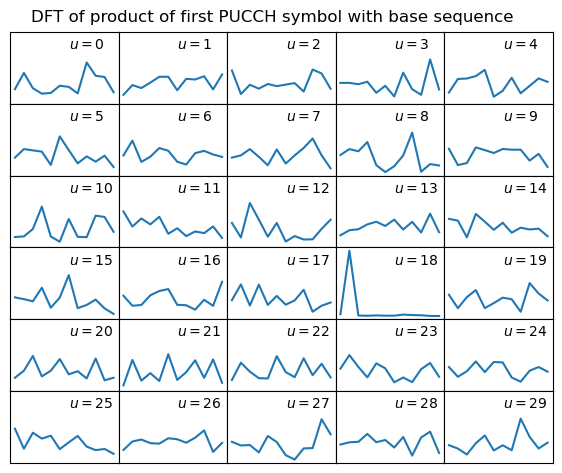

In [17]:
fig, axs = plt.subplots(6, 5, figsize=(7, 5.6), facecolor='w', sharex=True, sharey=True)
axsr = axs.ravel()
for u in range(30):
    axsr[u].plot(corr_r_uv[u])
    axsr[u].text(6, 10, f'$u = {u}$')
    axsr[u].set_yticks([])
    axsr[u].set_xticks([])
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('DFT of product of first PUCCH symbol with base sequence',
             y=0.92);

In [18]:
u = 18
ref_seq = r_uv[u]

# Determine the shift of the base sequence for each symbol
alpha = np.argmax(np.abs(np.fft.fft(symbols[active_slots] * np.conjugate(ref_seq))), axis=-1)

# Wipe off the shifted base sequence at each symbol
symbols_wipe = (
    np.conjugate(np.exp(1j*2*np.pi*alpha[:, :, np.newaxis]/12*np.arange(12)) * ref_seq)
    * symbols[active_slots])

# To be used for amplitude normalization
slot_power = np.average(np.abs(symbols_wipe)**2, axis=(1,2))

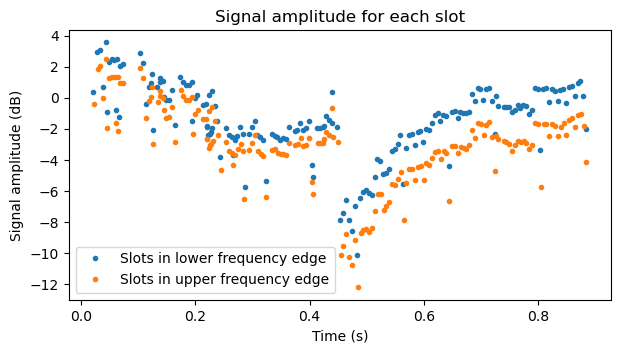

In [19]:
lower_edge = rb <= 1
plt.plot(t_slot[active_slots][lower_edge], 10*np.log10(slot_power[lower_edge]), '.',
         label='Slots in lower frequency edge')
plt.plot(t_slot[active_slots][~lower_edge], 10*np.log10(slot_power[~lower_edge]), '.',
         label='Slots in upper frequency edge')
plt.xlabel('Time (s)')
plt.ylabel('Signal amplitude (dB)')
plt.title('Signal amplitude for each slot')
plt.legend();

In [20]:
# Estimate delay using each symbol separately and then averaging for each slot
delay_est = np.empty((symbols_wipe.shape[0], symbols_wipe.shape[1]))
for j in range(symbols_wipe.shape[0]):
    for k in range(symbols_wipe.shape[1]):
        syms = symbols_wipe[j, k]
        delay_est[j, k] = np.polyfit(np.arange(12), np.angle(syms / np.average(syms)), 1)[0]
delay_est_avg = np.average(delay_est, axis=1)

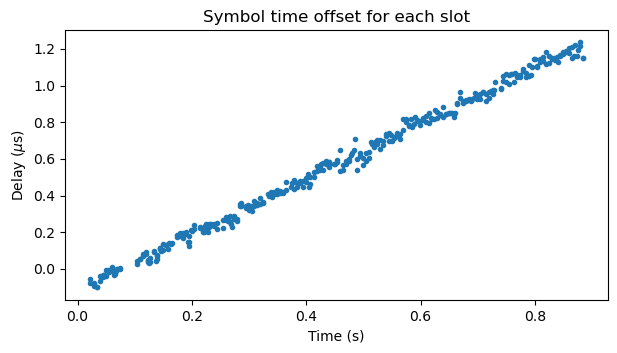

In [21]:
plt.plot(t_slot[active_slots], delay_est_avg/(2*np.pi*15e3)*1e6, '.')
plt.xlabel('Time (s)')
plt.ylabel('Delay ($\\mu$s)')
plt.title('Symbol time offset for each slot');

In [22]:
symbols_wipe_eq = (
    symbols_wipe / np.sqrt(slot_power)[:, np.newaxis, np.newaxis]
    * np.exp(-1j*delay_est_avg[:, np.newaxis, np.newaxis]*np.arange(12)))
symbols_per_sym = np.average(symbols_wipe_eq, axis=-1)

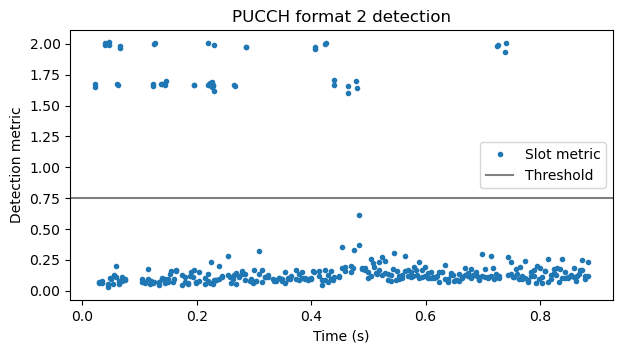

In [23]:
data_format2_candidate = (
    symbols_per_sym[:, [0, 2, 3, 4, 6]]
    * np.conjugate(normalize(symbols_per_sym[:, 1]))[:, np.newaxis])
qpsk_rms = np.sqrt(np.average(np.abs((data_format2_candidate**4 + 1)**2), axis=-1))
qpsk_rms_threshold = 0.75
plt.plot(t_slot[active_slots], qpsk_rms, '.',
         label='Slot metric')
plt.axhline(y=qpsk_rms_threshold, color='gray', label='Threshold')
plt.title('PUCCH format 2 detection')
plt.xlabel('Time (s)')
plt.ylabel('Detection metric')
plt.legend();

In [24]:
format2_sel = np.where(qpsk_rms <= qpsk_rms_threshold)[0]
format2_phase_ref = normalize(np.average(symbols_wipe_eq[format2_sel][:, 1], axis=-1))
format2_symbols = (
    symbols_wipe_eq[format2_sel]
    * np.conjugate(format2_phase_ref[:, np.newaxis, np.newaxis]))

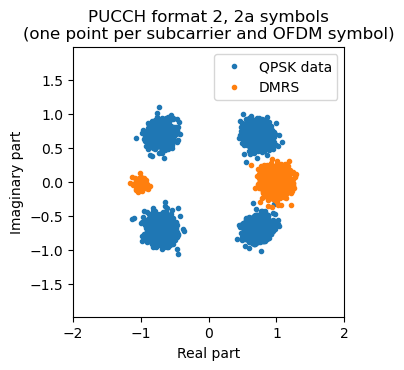

In [25]:
plt.figure(figsize=(3.5, 3.5))
format2_symbols_data = format2_symbols[:, [0, 2, 3, 4, 6]]
format2_symbols_dmrs = format2_symbols[:, [1, 5]]
plt.plot(format2_symbols_data.ravel().real, format2_symbols_data.ravel().imag, '.',
         label='QPSK data')
plt.plot(format2_symbols_dmrs.ravel().real, format2_symbols_dmrs.ravel().imag, '.',
         label='DMRS')
plt.legend()
plt.axis('equal')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('PUCCH format 2, 2a symbols\n(one point per subcarrier and OFDM symbol)');

In [26]:
format1_sel = np.array([a for a in range(symbols_per_sym.shape[0]) if a not in format2_sel])
format1_sel

array([  0,   1,   6,   7,  10,  11,  18,  19,  22,  23,  36,  37,  40,
        41,  44,  45,  50,  51,  70,  71,  80,  81,  82,  83,  84,  85,
        88,  89,  90,  91,  94,  95, 108, 109, 118, 119, 162, 163, 170,
       171, 178, 179, 186, 187, 192, 193, 292, 293, 296, 297])

In [27]:
format2_sel

array([  2,   3,   4,   5,   8,   9,  12,  13,  14,  15,  16,  17,  20,
        21,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        38,  39,  42,  43,  46,  47,  48,  49,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        72,  73,  74,  75,  76,  77,  78,  79,  86,  87,  92,  93,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 110, 111,
       112, 113, 114, 115, 116, 117, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 164, 165, 166, 167,
       168, 169, 172, 173, 174, 175, 176, 177, 180, 181, 182, 183, 184,
       185, 188, 189, 190, 191, 194, 195, 196, 197, 198, 199, 200, 201,
       202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214,
       215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 22

Text(0.5, 1.0, 'PUCCH format for each PUCCH subframe')

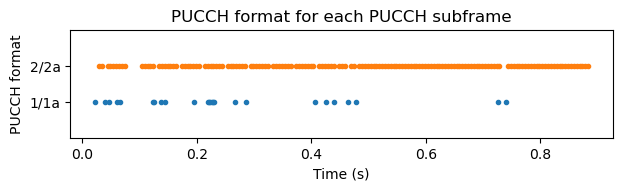

In [28]:
plt.figure(figsize=(7, 1.4))
plt.plot(t_slot[active_slots][format1_sel[::2]], [1] * (format1_sel.size//2), '.')
plt.plot(t_slot[active_slots][format2_sel[::2]], [2] * (format2_sel.size//2), '.')
plt.yticks([1, 2], ['1/1a', '2/2a'])
plt.ylim((0, 3))
plt.ylabel('PUCCH format')
plt.xlabel('Time (s)')
plt.title('PUCCH format for each PUCCH subframe')

In [29]:
# Check that the same format is detected in the two slots in each subframe
assert np.all(format1_sel[::2] + 1 == format1_sel[1::2])
assert np.all(format2_sel[::2] + 1 == format2_sel[1::2])

In [30]:
rb_format1 = rb[format1_sel]
set(zip(rb_format1[::2], rb_format1[1::2]))

{(1, 2), (2, 1), (3, 0)}

In [31]:
rb_format2 = rb[format2_sel]
set(zip(rb_format2[::2], rb_format2[1::2]))

{(0, 3)}

In [32]:
dmrs_format1_seq_idx = np.argmax(np.abs(np.fft.fft(symbols_per_sym[format1_sel, 2:5])),
                                 axis=-1)
dmrs_format1_seq_idx

array([1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 0, 0, 1, 2, 1, 2, 2, 1, 0, 2,
       2, 2, 2, 1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2,
       2, 2, 0, 0, 0, 0])

In [33]:
dmrs_format1_wipe = (symbols_wipe_eq[format1_sel, 2:5] 
                     * np.exp(-1j*2*np.pi*dmrs_format1_seq_idx[:, np.newaxis]*np.arange(3)/3)[..., np.newaxis])
format1_phase_ref = normalize(np.average(dmrs_format1_wipe, axis=(1, 2)))
format1_data = (
    symbols_wipe_eq[format1_sel][:, [0, 1, 5, 6]]
    * np.conjugate(format1_phase_ref)[:, np.newaxis, np.newaxis])
format1_dmrs = dmrs_format1_wipe * np.conjugate(format1_phase_ref)[:, np.newaxis, np.newaxis]
format1_w = np.array([[1, 1, 1, 1], [1, -1, 1, -1], [1, -1, -1, 1]])
w_sel = np.argmax(np.abs(np.average(format1_data, axis=-1) @ format1_w.T), axis=-1)
format1_data_wipe = format1_data * format1_w[w_sel][..., np.newaxis]

In [34]:
w_sel

array([1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 0, 0, 1, 2, 1, 2, 2, 1, 0, 2,
       2, 2, 2, 1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2,
       2, 2, 0, 0, 0, 0])

In [35]:
# Check that the sequence index used for the data symbols overlay code
# and for spreading the DMRS matches
assert np.all(w_sel == dmrs_format1_seq_idx)

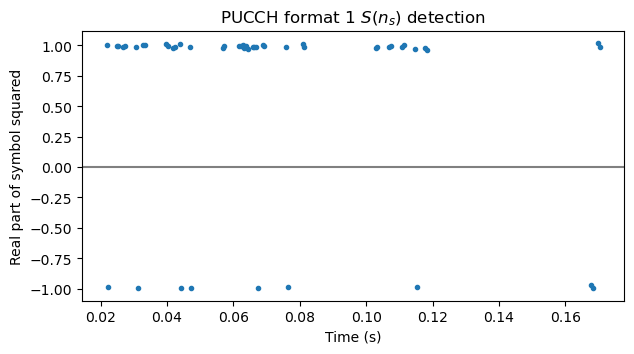

In [36]:
format1_sq = (np.average(format1_data_wipe, axis=(1, 2))**2).real
plt.plot(t_slot[format1_sel], format1_sq, '.')
plt.axhline(y=0, color='grey')
format1_S = format1_sq < 0
plt.title('PUCCH format 1 $S(n_s)$ detection')
plt.ylabel('Real part of symbol squared')
plt.xlabel('Time (s)');

In [37]:
format1_data_wipe_S = format1_data_wipe.copy()
format1_data_wipe_S[format1_S] *= -1j

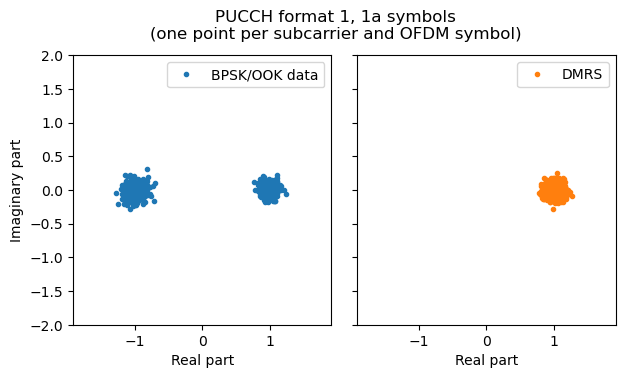

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5), sharey=True)
axs[0].plot(format1_data_wipe_S.ravel().real, format1_data_wipe_S.ravel().imag, '.',
            label='BPSK/OOK data')
axs[1].plot(format1_dmrs.ravel().real, format1_dmrs.ravel().imag, '.',
            label='DMRS', color='C1')
for ax in axs:
    ax.axis('equal')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.legend()
    ax.set_xlabel('Real part')
axs[0].set_ylabel('Imaginary part')
fig.subplots_adjust(wspace=0.1)
fig.suptitle('PUCCH format 1, 1a symbols\n(one point per subcarrier and OFDM symbol)', y=1.01);

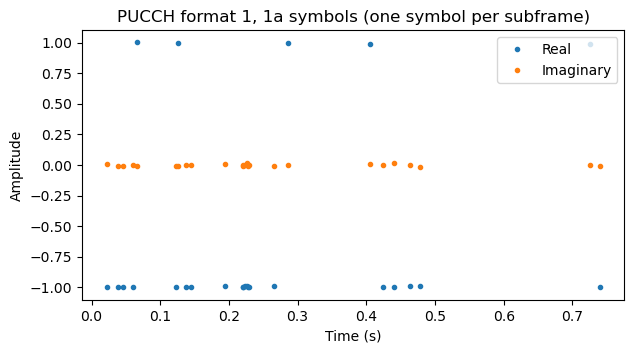

In [39]:
format1_bits = np.average(np.average(format1_data_wipe_S, axis=(1, 2)).reshape(-1, 2), axis=-1)
t_format1 = t_slot[active_slots][format1_sel[::2]]
plt.plot(t_format1, format1_bits.real, '.', label='Real')
plt.plot(t_format1, format1_bits.imag, '.', label='Imaginary')
plt.title('PUCCH format 1, 1a symbols (one symbol per subframe)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend();

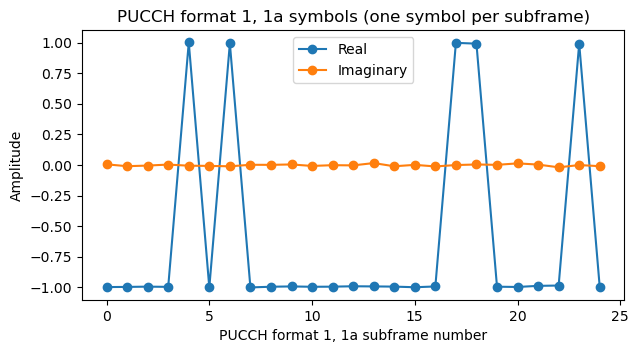

In [40]:
format1_bits = np.average(np.average(format1_data_wipe_S, axis=(1, 2)).reshape(-1, 2), axis=-1)
t_format1 = t_slot[active_slots][format1_sel[::2]]
plt.plot(format1_bits.real, 'o-', label='Real')
plt.plot(format1_bits.imag, 'o-', label='Imaginary')
plt.title('PUCCH format 1, 1a symbols (one symbol per subframe)')
plt.xlabel('PUCCH format 1, 1a subframe number')
plt.ylabel('Amplitude')
plt.legend();